# MiniAI Utilities

<img src="robot.jpg" alt="Data" width="420">

I have been taking [Part 2 of FastAI courses](https://course.fast.ai/Lessons/part2.html), which covers matrix multiplication to stable diffusion. In the course, we built MiniAI from scratch. MiniAI is a small and flexible library that makes building AI tools very easy. I am almost done with the course, and I want to share some utility functions I have built on top of MiniAI. These are very useful to me, and I hope you find it that way as well. Here's a [code](https://github.com/galopyz/course22p2/blob/master/nbs/xtras.ipynb) for this notebook.

Some additional functionalities added to miniai. 
- When training models, output time along with loss and metrics.
- Get data from pytorch datasets.
- Plot weight statistics after fit using `ActivationStats`.
- `MyNorm` is a mixture of `LayerNorm`'s simplicity and `Batchnorm`'s way of taking means/stds.

## Import libraries

Let's import some libraries first. Cells that start with `#|export` are exported using [nbdev](https://nbdev.fast.ai/), which turns jupyter notebook into python script.

In [25]:
#|export
from time import time
from copy import copy
from torcheval.metrics import Mean
import torchvision, torch
from torch import tensor, nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import fastcore.all as fc
import matplotlib.pyplot as plt
from fastprogress import progress_bar,master_bar

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [26]:
import torch
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
from torcheval.metrics import MulticlassAccuracy
import torch.nn.functional as F

## get_dls

In FastAI's course22 part 2, we use Fashion MNIST datasets from Hugging Face. Hugging Face datasets store images with PyArrow, and we have to convert them into tensors each batch for training. Therefore, we could use `get_dls` to create `DataLoaders` from Pytorch datasets. 

In [27]:
#|export
def batch_tfrm(img): return (ToTensor()(img) - tensor(0.29)) / tensor(0.35)

In [28]:
#|export
def get_dls(bs=1024, seed=42, tfrm=batch_tfrm, num_workers=4):
    """Grab MNIST fasion data using pytorch dataset."""
    set_seed(seed)
    bs = bs
    trn_ds = datasets.FashionMNIST(root=".", train=True, download=True, transform=tfrm)
    val_ds = datasets.FashionMNIST(root=".", train=False, download=True, transform=tfrm)
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=num_workers)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=num_workers)
    return DataLoaders(trn_dl, val_dl)

In [29]:
dls = get_dls()
xb, yb = next(iter(dls.train))
xb.shape, yb

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4,  ..., 8, 0, 3]))

## format_time

This is a function from [fastprogress](https://github.com/fastai/fastprogress). It converts seconds to mm:ss and h:mm:ss if there is an hour.

In [30]:
#|export
# Code from fastcore https://github.com/fastai/fastprogress/blob/master/fastprogress/core.py#L7
def format_time(t):
    "Format `t` (in seconds) to (h):mm:ss"
    t = int(t)
    h,m,s = t//3600, (t//60)%60, t%60
    if h!= 0: return f'{h}:{m:02d}:{s:02d}'
    else:     return f'{m:02d}:{s:02d}'

In [31]:
format_time(3)

'00:03'

It truncates all the decimals. 

In [32]:
format_time(3.999)

'00:03'

In [33]:
format_time(65)

'01:05'

In [34]:
format_time(4888)

'1:21:28'

## MetricsCB

We encountered `MetricsCB` in `09_learner.ipynb` notebook. This callback computes loss and metric functions. After epoch, it logs current epoch, whether in training or not, loss and metric values. 

I thought it would be useful to also add time into the callback, so I used `format_time` for that.

In [35]:
#|export
class MetricsCB(Callback):
    """Added time for the original."""
    def __init__(self, *ms, device=def_device, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, x): print(x)

    def before_fit(self, learn): learn.metrics = self

    def before_epoch(self, learn):
        for m in self.all_metrics.values(): m.reset()
        self.start_time = time()

    def after_epoch(self, learn):
        log = {k: f'{v.compute():.3f}' for k, v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = learn.model.training
        t = time() - self.start_time
        log['time'] = format_time(t)
        self._log(log)

    def after_batch(self, learn):
        x, y = learn.batch
        for m in self.metrics.values():
            m.update(to_cpu(learn.preds), to_cpu(y))
        self.loss.update(to_cpu(learn.loss), weight=len(x))

Let's take a look at an example.

In [36]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

In [37]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics]
learn = Learner(nn.Sequential(*cnn_layers()), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

{'accuracy': '0.298', 'loss': '2.076', 'epoch': 0, 'train': True, 'time': '00:01'}
{'accuracy': '0.370', 'loss': '1.962', 'epoch': 0, 'train': False, 'time': '00:00'}
{'accuracy': '0.636', 'loss': '0.972', 'epoch': 1, 'train': True, 'time': '00:01'}
{'accuracy': '0.740', 'loss': '0.692', 'epoch': 1, 'train': False, 'time': '00:00'}


## ProgressCB

Let's take a look at `ProgressCB`, which we also encountered in `09_learner.ipynb` notebook. This callback adds nice progress bar, which we can visualize the progress. It can also plot train and valid losses in different frequencies. When plot is True, `update_freq` can be `batch`, `epoch`, or `fit`. Since updating each batch is too frequent, I wanted to add some options. 

In [38]:
# |export
class ProgressCB(Callback):
    """
    Plot frequency options:
    batch: every batch
    epoch: every epoch
    fit: first two epochs and after fit
    """
    order = MetricsCB.order+1
    def __init__(self, plot=False, update_freq='fit', epoch_nums=2): fc.store_attr()
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
        
    def _update_graph(self, learn, valid):
        n = int(valid)
        self.mbar.update_graph(
            [[fc.L.range(self.losses), self.losses],
            [fc.L.range(learn.epoch+n).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses and self.update_freq=='batch': self._update_graph(learn, valid=False)
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                if self.update_freq=='epoch' or (self.update_freq=='fit' and learn.epoch<self.epoch_nums): 
                    self._update_graph(learn, valid=True)

    def after_fit(self, learn):
        if self.plot and self.update_freq == 'fit': self._update_graph(learn, valid=True)

accuracy,loss,epoch,train,time
0.286,2.120,0,True,00:01
0.571,1.095,0,False,00:00
0.663,0.907,1,True,00:01
0.672,0.817,1,False,00:00
0.741,0.676,2,True,00:01
0.763,0.629,2,False,00:00
0.777,0.589,3,True,00:01
0.794,0.556,3,False,00:00
0.804,0.522,4,True,00:01
0.805,0.507,4,False,00:00


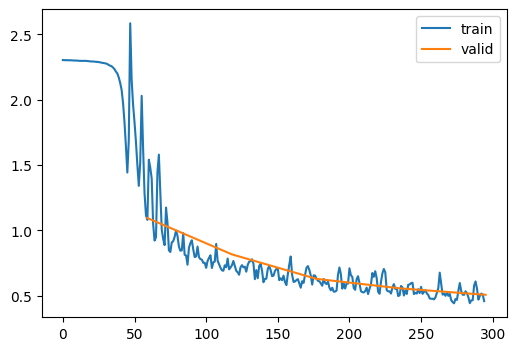

In [39]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(nn.Sequential(*cnn_layers()), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(5)

## ActivationStats

I only added `after_fit` to `ActivationStats`, which simply plots parameter statistics after fitting. It just saves typing.

In [40]:
#|export
class ActivationStats(HooksCallback):
    """Add after fit to plot statistics."""
    def __init__(self, mod_filter=fc.noop, plot=False):
        super().__init__(append_stats, mod_filter)
        self.plot = plot

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

    def after_fit(self, learn):
        if self.plot: self.plot_stats(figsize=(8, 3))
        super().after_fit(learn)

## MyNorm

`MyNorm` is a normalization technique which combines the simplicity of `LayerNorm` and calculation of mean and standard deviation like `BatchNorm`. Normalization techniquea re covered in (11_initializing.ipynb)[https://github.com/galopyz/course22p2/blob/master/nbs/11_initializing.ipynb] I tested on `14_augment.ipynb` notebook, and `MyNorm` performs as good as `nn.BatchNorm2d`. In [14_augment-Copy1](https://github.com/galopyz/course22p2/blob/master/nbs/14_augment-Copy1.ipynb), I used `BatchNorm`, `LayerNorm`, and `MyNorm` without momentum. In [14_augment-Copy2](https://github.com/galopyz/course22p2/blob/master/nbs/14_augment-Copy2.ipynb), I used `MyNorm` with momentum. In these notebooks, total time spent is not very accurate. Simply adding time for each epochs gave me much higher value.

In [41]:
#|export
class MyNorm(nn.Module):
    """Simple like layernorm but taking mean/std like batch norm."""
    def __init__(self, dummy, eps = 1e-4):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
    
    def forward(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

This `MyNorm` has momentum like `BatchNorm`. It does not necessarily train better than one without momentum. If we do a momentum with 1, it is same as having no momentum.

In [42]:
#|export
class MyNorm(nn.Module):
    """Simple like layernorm but taking mean/std like batch norm.
    With momentum."""
    def __init__(self, nf, mom=0.1, eps = 1e-4):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
        self.register_buffer('var',  torch.ones(1,nf,1,1))
        self.register_buffer('mean', torch.zeros(1,nf,1,1))
    
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.mean.lerp_(m, self.mom)
        self.var.lerp_ (v, self.mom)
        return m,v

    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.mean,self.var
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mult + self.add

## Conclusion

We looked at some utility functions, and I found them to be very useful when I was studying the course. For instance, finding out roughly how long it took to train an epoch was helpful. `MyNorm` was fun to try out in different models. I found out that when training for 50 epochs with data augmentation, it really didn't matter which normalization technique I used. They were about the same. Therefore, it was better to use optimized Pytorch's `nn.BatchNorm2d` for speed. I hope you found these useful as well.